In [6]:
using Gen, Plots

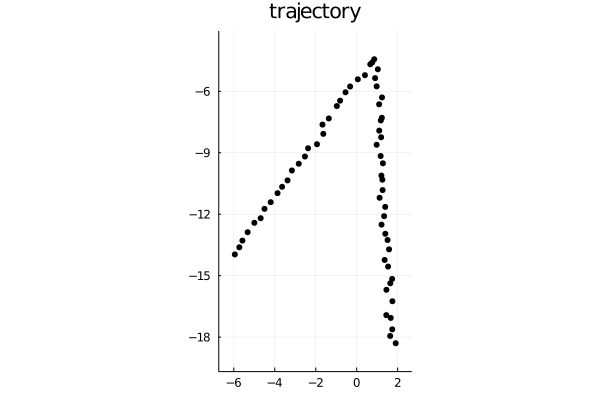

In [25]:
# Input - Trajectory Data (retrieved from physics model)
xs = [-5.950857394849689, -5.732010560831773, -5.580991994056934, -5.325627078129187, -4.997871406373859, -4.690249541976312, -4.502801279432661, -4.198802578982614, -3.8652273967792414, -3.6428990937063213, -3.377558214902028, -3.1656570504882184, -2.830237123073675, -2.5281778150720604, -2.375297793708614, -1.9401933873715762, -1.6319046597476836, -1.6717638204182148, -1.362654961717607, -0.9693426291864525, -0.811144262538797, -0.5480708745819656, -0.32266374948988513, 0.05383282297858155, 0.4016871505526071, 0.660565225479464, 0.8550662882052231, 0.7607954986603729, 1.0312793009619847, 0.8979837945988044, 0.9735902060931276, 1.2348843663875695, 1.0928824145364817, 1.227255075623881, 1.1757547665617354, 1.0999641340307935, 1.1917436262709766, 0.9728847526387326, 1.1692510845270632, 1.278526190484237, 1.2052413081734674, 1.2520957076015669, 1.2653249232564354, 1.1170372715656347, 1.3916064681498654, 1.338226336426837, 1.2119699846671146, 1.3964169886158053, 1.5054479944712122, 1.5788396428356881, 1.3630872692620954, 1.5306201668825816, 1.7288599825079936, 1.6389469600708257, 1.450110864118712, 1.742881165478771, 1.4450937916425022, 1.6608816089351017, 1.7358157777226857, 1.6330369315350954, 1.9033722624552583]
ys = [-13.962826731948132, -13.6158458546513, -13.288690845417696, -12.878581968295736, -12.418912894929226, -12.194764895371145, -11.738201280520876, -11.412386793782822, -10.971006926703087, -10.661435707109753, -10.348379284735742, -9.864703294279812, -9.535258910001595, -9.183148888409631, -8.780725973290599, -8.583211783612073, -8.076055050588135, -7.625419566760801, -7.324452518333433, -6.7199161049526275, -6.45704037194385, -6.047466726957722, -5.764535381921893, -5.413483305869026, -5.211529710062647, -4.678972607715271, -4.434929059461678, -4.585310762667825, -4.9228541200239535, -5.355922713224732, -5.7583352804706305, -6.298447589241116, -6.633125759943555, -7.293069009679432, -7.420856555405638, -7.918603844111726, -8.241926429018134, -8.610009090764237, -9.158611408700255, -9.515530557305553, -10.115289822024357, -10.313414513976078, -10.822462000953001, -11.196390613444262, -11.64230335894282, -12.09530361338669, -12.50917782304498, -12.95475985019972, -13.259601481366905, -13.715924753517145, -14.232550175047923, -14.55624473483772, -15.160620132788933, -15.372811349780754, -15.689990396433817, -16.249640966579886, -16.927653384253517, -17.063515834117517, -17.621194875062653, -17.944801585157652, -18.298492962768307]
velocity = 0.5
jitter = 0.1;

# Set parametrization
@assert(length(xs) == length(ys))
num_points = length(xs);
num_t = num_points * velocity;
ts = collect(range(0., stop=num_t, length=num_points));

# Show trajectory
xlen = maximum(xs)-minimum(xs)
ylen = maximum(ys)-minimum(ys)
xlim = (minimum(xs)-0.1*xlen,maximum(xs)+0.1*xlen)
ylim = (minimum(ys)-0.1*ylen,maximum(ys)+0.1*ylen)
xy_plot = scatter(xs, ys, color="black", label=nothing, title="trajectory", xlim=xlim, ylim=ylim, aspect_ratio=:equal)
Plots.plot(xy_plot)



In [18]:
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    x0::Float64
    y0::Float64
    angle::Float64
    interval::Interval
end

In [35]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(t::Float64, node::LeafNode)
    @assert t >= node.interval.l && t <= node.interval.u
    length = t - node.interval.l
    return [node.x0 + cos(node.angle)*length, node.y0 + sin(node.angle)*length]
end;

function get_value_at(t::Float64, node::InternalNode)
    @assert t >= node.interval.l && t <= node.interval.u
    if t <= node.left.interval.u
        get_value_at(t, node.left)
    else
        get_value_at(t, node.right)
    end
end;

function get_normal(left::LeafNode, right::LeafNode)
    # left's tail and right's head should roughly coincide
    # the "normal" is the bisector of the angle between, pointing "in"
    dir1 = [cos(left.angle), sin(left.angle)]
    dir2 = [cos(right.angle), sin(right.angle)]
    dirn = dir2 - dir1
    length = ((normal[1])^2 + (normal[2])^2)^.5
    return dirn/length
end;

In [20]:
# 2-piece linear
@gen function generate_leaf(l::Float64, u::Float64, x0::Float64, y0::Float64)
    interval = Interval(l, u)
    x0 = ({:x0} ~ normal(x0,jitter))
    y0 = ({:y0} ~ normal(y0,jitter))
    angle = ({:angle} ~ uniform(0,2*pi))
    return LeafNode(x0, y0, angle, interval)
end;

@gen function generate_segments(l::Float64, u::Float64, x0::Float64, y0::Float64)
    interval = Interval(l, u)
    frac = ({:frac} ~ beta(2, 2))
    llen = (u - l) * frac
    mid  = l + llen
    left = ({:left} ~ generate_leaf(l, mid, x0, y0))
    
    x1 = left.x0 + cos(left.angle)*llen
    y1 = left.y0 + sin(left.angle)*llen
    right = ({:right} ~ generate_leaf(mid, u, x1, y1))
    return InternalNode(left, right, interval)
end;

In [28]:

function do_inference(model, (ts,x0,y0,), xs, ys, amount_of_computation)
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
    end
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = Gen.importance_resampling(model, (ts,x0,y0,), observations, amount_of_computation);
    return trace
end;

# Our full model
@gen function changepoint_model(ts::Vector{Float64}, x0::Float64, y0::Float64)
    node = ({:tree} ~ generate_segments(minimum(ts), maximum(ts), x0, y0))
    # noise = ({:noise} ~ gamma(0.5, 0.5))
    noise = jitter
    for (i, t) in enumerate(ts)
        {(:x, i)} ~ normal(get_value_at(t, node)[1], noise)
        {(:y, i)} ~ normal(get_value_at(t, node)[2], noise)
    end
    return node
end;

In [29]:
function render_node!(node::LeafNode)
    length = node.interval.u - node.interval.l
    plot!([node.x0, node.x0+cos(node.angle)*length], [node.y0, node.y0+sin(node.angle)*length], label=nothing, linewidth=5)
end
function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;
function render_segments_trace(trace)
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=ylim, aspect_ratio=:equal)
    render_node!(node)
    return fig
end;

function gridded(renderer::Function, traces)
    Plots.plot(map(renderer, traces)..., xlim=xlim, ylim=ylim, aspect_ratio=:equal)
end;

function render_changepoint_model_trace(trace; show_data=true)
    ts = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    fig = render_segments_trace(trace)
    render_node!(node)
    if show_data
        xs = [trace[(:x, i)] for i=1:length(ts)]
        ys = [trace[(:y, i)] for i=1:length(ts)]
        scatter!(xs, ys, c="gray", label=nothing, alpha=0.2, markersize=3)
    end
end;

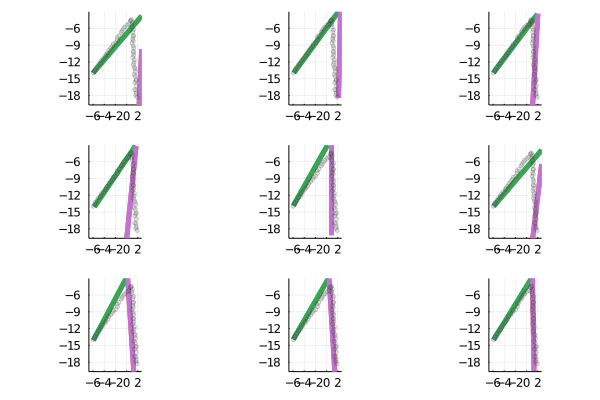

In [30]:
traces = [do_inference(changepoint_model, (ts,xs[1],ys[1],), xs, ys, c) for c=10000:2000:26000];
gridded(render_changepoint_model_trace, traces)

In [38]:
node = Gen.get_retval(traces[9]);

intersection = [node.right.x0, node.right.y0]; # location of bounce
direction = get_normal(node.left, node.right); # direction of normal vector at bounce

println(intersection)
println(direction)

[1.0405716676163246, -2.4843592401769126]
[-0.2641794665509624, -0.9644735400480663]
